## Welcome to the soybean analysis notebook
Authors: Nicholas A Buchert

In [21]:
import pandas as pd
import numpy as np
import bisect
from math import pi
from itertools import chain
from numpy import arange
from sklearn import datasets, linear_model, mixture
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import BrBG as bokeh_colors
from bokeh.models import ColorBar, LinearColorMapper
from bokeh.io import output_notebook
from collections import OrderedDict

# Read data from project workspace
data = pd.read_excel('./realmonthlycommodityexchangerates.xlsx')

us_export_cols = ['Soybeans', 'U.S. merchandise exports to the World',
       'U.S. agricultural exports to the World', 'Bulk', 'Corn', 'Cotton',
       'Rice', 'Tobacco', 'Wheat', 'Intermediates', 'Soymeal',
       'Soybean & Vegetable Oil', 'Feeds & Fodders', 'Distillers Grain',
       'Hides & Skins', 'Consumer Oriented', 'Tree Nuts', 'Dairy Products',
       'Prepared Food', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Juices & Beverages',
       'Beef & Beef Products', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Wine & Beer', 'Agricultural Related 5/']

regr = linear_model.LinearRegression()
x = data['Hides & Skins'].values.reshape(-1, 1)
y = data['Soybeans'].values.reshape(-1,1)
regr.fit(x, y)

print('Coefficients: {}, Intercept: {}'.format(regr.coef_, regr.intercept_))


Coefficients: [[1.248068]], Intercept: [-22.53247868]


## Gaussian Mixture Classification

In [8]:
output_notebook()

# Constuct feature set
X = data[['Corn', 'Soybeans']]

# Create gaussian mixutre model with 3 tied clusters
gmm = GaussianMixture(n_components=3,covariance_type='tied',random_state=1234)
gmm.fit(X)

# Generate cluster predictions from gmm (Run on entire dataset, no test/train)
labels = gmm.predict(X)
frame = pd.DataFrame(X)
frame['cluster'] = labels
frame.columns = ['Corn', 'Soybeans', 'cluster']
saved_data = X

# Create plot and define colors for points
plt = figure(title="Corn V.S. Soybeans (US Exports)", plot_width=400, plot_height=400)
color=['navy','brown','purple']

# For each cluster, plot circles on the plot
for k in range(0,3):
    X = frame[frame["cluster"]==k]
    plt.circle(X['Corn'], X['Soybeans'], size=10, color=color[k], alpha=0.5)
    #plt.scatter(X['Cotton'],X['Soybeans'],c=color[k])
    
plt.xaxis.axis_label = 'Corn'
plt.yaxis.axis_label = 'Soybeans'
show(plt)

# If wanted, export bokeh plot to PNG
# from bokeh.io import export_png
# export_png(plt, filename="corn_v_soybean_clustering.png")

Loading BokehJS ...

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


'/home/nbuser/library/corn_v_soybean_clustering.png'

## Pearson's correlation heat map for US exports

In [23]:
selection = data[us_export_cols]
corr = selection.corr()

# Simplified column names to fit better in plot
us_export_cols_simple = ['Soybeans', 'U.S. Merch Exp',
       'U.S. Ag Exp', 'Bulk', 'Corn', 'Cotton',
       'Rice', 'Tobacco', 'Wheat', 'Intermediates', 'Soymeal',
       'Soybean & Veg Oil', 'Feeds & Fodders', 'Distillers Grain',
       'Hides & Skins', 'Consumer Oriented', 'Tree Nuts', 'Dairy Products',
       'Prepared Food', 'Fruit',
       'Vegetables', 'Juices & Beverages',
       'Beef & Beef Products', 'Pork & Pork Products',
       'Poultry', 'Wine & Beer', 'Ag Rel']

output_notebook()

# I forgot to list the link where I referenced to get the rest of the code in this cell...
colors = list(bokeh_colors[9])
labels = us_export_cols_simple
nlabels = len(labels)

def get_bounds(n):
    """Gets bounds for quads with n features"""
    bottom = list(chain.from_iterable([[ii]*nlabels for ii in range(nlabels)]))
    top = list(chain.from_iterable([[ii+1]*nlabels for ii in range(nlabels)]))
    left = list(chain.from_iterable([list(range(nlabels)) for ii in range(nlabels)]))
    right = list(chain.from_iterable([list(range(1,nlabels+1)) for ii in range(nlabels)]))
    return top, bottom, left, right

def get_colors(corr_array, colors):
    """Aligns color values from palette with the correlation coefficient values"""
    ccorr = arange(0, 1, 1/(len(colors)))
    color = []
    for value in corr_array:
        ind = bisect.bisect_left(ccorr, value)
        color.append(colors[ind-1])
    return color

p = figure(plot_width=900, plot_height=600,
           x_range=(0,nlabels), y_range=(0,nlabels),
           title="Pearson's Coefficients on Commodities (US Exports)",
           toolbar_location=None, tools='')

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/4
p.yaxis.major_label_orientation = 0

top, bottom, left, right = get_bounds(nlabels)  # creates sqaures for plot
color_list = get_colors(corr.values.flatten(), colors)

p.quad(top=top, bottom=bottom, left=left,
       right=right, line_color='white',
       color=color_list)

# Set ticks with labels
ticks = [tick+0.5 for tick in list(range(nlabels))]
tick_dict = OrderedDict([[tick, labels[ii]] for ii, tick in enumerate(ticks)])

# Create the correct number of ticks for each axis 
p.xaxis.ticker = ticks
p.yaxis.ticker = ticks

# Override the labels and alignment
p.xaxis.major_label_overrides = tick_dict
p.yaxis.major_label_overrides = tick_dict
p.yaxis.major_label_text_align = 'right'

# Setup color bar and show the heat map
mapper = LinearColorMapper(palette=colors, low=0, high=1)
color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

In [24]:
def get_slope_arr(data,col_names):
    ''' Calculate rate of change (slope) between consecutive 
    points and return a dataframe of all slopes. '''
    slope_df = pd.DataFrame(columns=col_names)
    for index, row in data.iterrows():
        if index <= data.shape[0] -2:
            slope_df.loc[index] = data.loc[index+1] - row
    return slope_df

In [25]:
p2 = figure(plot_width=900, plot_height=600,
           x_range=(0,nlabels), y_range=(0,nlabels),
           title="Pearson's Coefficients on Commodity Slopes",
           toolbar_location=None, tools='')

slope_data = get_slope_arr(data,us_export_cols)    
slope_corr = slope_data.corr()

p2.xgrid.grid_line_color = None
p2.ygrid.grid_line_color = None
p2.xaxis.major_label_orientation = pi/4
p2.yaxis.major_label_orientation = 0

top, bottom, left, right = get_bounds(nlabels)  # creates sqaures for plot
color_list = get_colors(slope_corr.values.flatten(), colors)

p2.quad(top=top, bottom=bottom, left=left,
       right=right, line_color='white',
       color=color_list)

# Set ticks with labels
ticks = [tick+0.5 for tick in list(range(nlabels))]
tick_dict = OrderedDict([[tick, labels[ii]] for ii, tick in enumerate(ticks)])
# Create the correct number of ticks for each axis 
p2.xaxis.ticker = ticks
p2.yaxis.ticker = ticks
# Override the labels 
p2.xaxis.major_label_overrides = tick_dict
p2.yaxis.major_label_overrides = tick_dict

p2.yaxis.major_label_text_align = 'right'

# Setup color bar
mapper = LinearColorMapper(palette=colors, low=0, high=1)
color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
p2.add_layout(color_bar, 'right')
show(p2)

## Messing around with DBSCAN classifier...

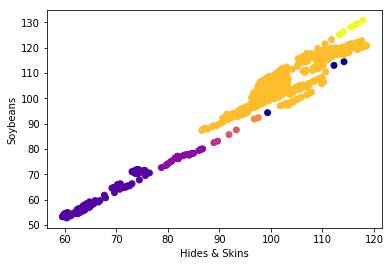

In [26]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data[['Hides & Skins', 'Soybeans']].values

# I think this defaults to 5 clusters???
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.123, min_samples = 2)
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Hides & Skins")
plt.ylabel("Soybeans")
plt.show()

In [ ]:
# If needed, install selenium and phantomjs to hosted compute engine to allow for exporting of PNG bokeh plots
!conda install -y selenium phantomjs